In [1]:
# pip install --upgrade tensorflow-probability

In [2]:
#  pip install tfp-nightly

In [3]:
pip install pyAstronomy

     |████████████████████████████████| 716kB 6.3MB/s 
  Created wheel for pyAstronomy: filename=PyAstronomy-0.16.0-cp37-none-any.whl size=504499 sha256=a1a6859f35b5f137d3fd5a33cdde489b25330ede97f84e60626904d53fbc5f71
  Stored in directory: /root/.cache/pip/wheels/93/af/aa/931d34dfc98c7f7fb4514fb9da32cac3584895cc03e873bdd1
Successfully built pyAstronomy


In [4]:
pip install arviz


     |████████████████████████████████| 1.6MB 6.6MB/s 
     |████████████████████████████████| 768kB 29.1MB/s 
     |████████████████████████████████| 4.7MB 46.6MB/s 
     |████████████████████████████████| 317kB 38.9MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [5]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import io
from PyAstronomy import pyasl
import time
r = pyasl.BallesterosBV_T()
b = pyasl.Ramirez2005()

uploaded = files.upload()

data0 = data = np.array(pd.read_csv(io.BytesIO(uploaded['SItable1.csv'])))

Saving SItable1.csv to SItable1.csv


In [6]:
import tensorflow.math as tf_m
def mean_fn(x, y, a, b, c, d):
  return (np.exp(x)*1000)**a * b*(y - c)**d #the m relation was through trial and error
#fn from Barnes 2007
def mean_fn_hmc(x):
  a = 0.5189
  b=0.75
  c=0.4
  d=0.601
  e = 2.718#np.float64(np.exp(1))
  BV = (5601/10**x[:,1])**3/2 - 0.3
  return (e**(x[:,0])*1000)**a * b*(BV - c)**d
  #return tf.convert_to_tensor(p, dtype=np.float64)#((e**x[:,0])*1000)**0.5189 * 0.75*(BV)**0.601

In [7]:
# # mean_fn_hmc(observation_index_points)- p
# BV = (5601/10**observation_index_points[:,1])**3/2 #- 0.3
# ((2.718**observation_index_points[:,0])*1000)**0.5189 * 0.75*(BV)**0.601

In [8]:
te = data0[:,2].tolist()
tee= data0[:,3].tolist()
age = data0[:,4].tolist()
agle = data0[:,5].tolist()
ague = data0[:,6].tolist()
mass = data0[:,7].tolist()
massle = data0[:,8].tolist()
massue = data0[:,9].tolist()
p = data0[:,21].tolist()
pl = data0[:,22].tolist()
pu = data0[:,23].tolist()

mass_error = (np.array(massle) + np.array(massue))/2
age_error = (np.array(agle)+np.array(ague))/2#np.log(age) - np.log(np.array(age) - np.array(agle))
p_error = ((np.array(pl)+np.array(pu))/2)#(np.log(p) - np.log(np.array(p)-np.array(pl)))


In [9]:
indctr = data0[:,24]
index = 0
for i in range(0, len(p)-index):
  if age[i]<2 or age[i]>11 or p[i]<5 or indctr[i]>1:
    index = index+1
for i in range(0, len(p)-index):
  if age[i]<2 or age[i]>11 or p[i]<5 or indctr[i]>1:
    te.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    tee.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    age.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    agle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    ague.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    mass.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massue.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    p.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pl.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pu.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    

mass_error = (np.array(massle) + np.array(massue))/2
age_error = (np.array(agle)+np.array(ague))/2#np.log(age) - np.log(np.array(age) - np.array(agle))
p_error = ((np.array(pl)+np.array(pu))/2)#/np.array(p)#(np.log(p) - np.log(np.array(p)-np.array(pl)))

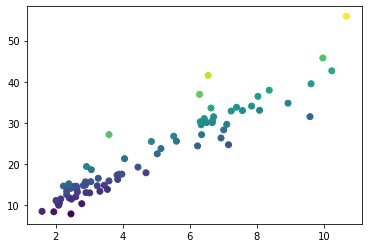

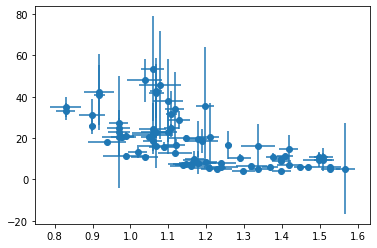

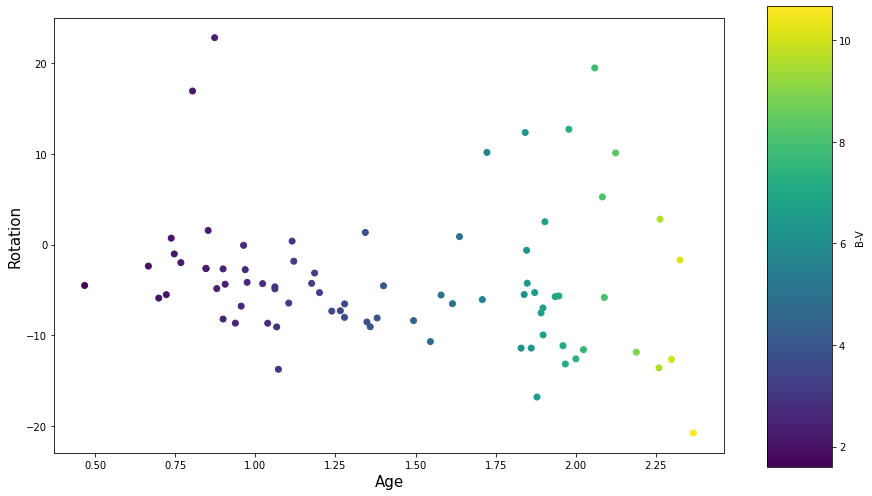

In [10]:
data = np.array([te, p, age, mass]).T
a = 0.5189
b=0.75
c=0.4
d=0.601
f = -0.6
X1 = np.log(data[:,2]) #age
X2 = r.t2bv(data[:,0])#data[::al,2] #B_V
X3 = data[:, 3] #mass
x = mean_fn(X1, X2, a, b, c, d)
plt.scatter(data[:,2], x, c=X2, cmap='viridis')
plt.show()
plt.errorbar(X3, p, xerr=mass_error, yerr=p_error, fmt='o')#, c=X2, cmap='hsv')
subtract = data[:,1]-x
plt.show()
fig = plt.figure(figsize=(12, 8))
plt.scatter(X1, subtract, c=data[:,2], cmap='viridis')
plt.xlabel('Age', size=15)
plt.ylabel('Rotation', size=15)
#plt.subplots_adjust(bottom=np.min(X2), top=np.max(X2))
cax = plt.axes([0.95, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='B-V')
plt.show()


In [100]:
tf.enable_v2_behavior()
t1 = time.perf_counter()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# observations from a known function at some random points.
X1 = np.log(age) #age
X2 = np.log10(te)#data[::al,2] #B_V
X3 = np.array(mass)
observation_index_points = np.dstack([X1, X2]).reshape(-1, 2)
observation_index_error =np.dstack([np.array(age_error/age), 0.43*np.array(tee)/np.array(te)]).reshape(-1, 2)
shape = np.array(observation_index_points.shape)
resolution = len(X2)
X1_test = np.log(np.linspace( np.min(data[::,2]), np.max(data[::,2]), num=resolution ))
X2_test = np.linspace( np.min(X2), np.max(X2), num=resolution )
X3_test = np.linspace( np.min(X3), np.max(X3), num=resolution )
X_test = np.dstack([X1_test, X2_test]).reshape(resolution,2)# resolution, resolution, 3)

a = 0.5189
b=0.75
c=0.4
d=0.601

Y = observations = (np.array(p) - mean_fn(X1, r.t2bv(np.array(te)), a, b, c, d))
noise_variance = p_error**0.5

sigma_init = 0.1*(max(Y) - min(Y))**0.5
l_scale = 4*(max(X2) - min(X2))
gaussian_process_model = tfd.JointDistributionSequential([
  tfd.LogNormal(sigma_init*np.ones(shape), np.float64(.00001)),
  tfd.LogNormal(l_scale*np.ones(shape), np.float64(.00001)),
  tfd.LogNormal(observation_index_points, observation_index_error),
  # tfd.Normal(X2.reshape(-1), 0.04*X1.reshape(-1)),
  # tfd.Normal(X3.reshape(-1), 0.04*X1.reshape(-1)),
  lambda amplitude, length_scale, observations1_: tfd.GaussianProcess(
      kernel=psd_kernels.ExponentiatedQuadratic(amplitude, length_scale), mean_fn=mean_fn_hmc,
      index_points=observations1_, observation_noise_variance=observation_index_error)])

initial_chain_states = [
    sigma_init * tf.ones(shape, dtype=np.float64, name='init_amplitude'),
    l_scale * tf.ones(shape, dtype=np.float64, name='init_length_scale'),
    tf.convert_to_tensor(observation_index_points, dtype=np.float64, name='observations1_')]
    # tf.convert_to_tensor(X2.reshape(-1), dtype=np.float64, name='observations2_'),
    # tf.convert_to_tensor(X3.reshape(-1), dtype=np.float64, name='observations3_')]

initial_steps = [
    5e-6* tf.ones(shape, dtype=np.float64),
    5e-6* tf.ones(shape, dtype=np.float64),
    tf.convert_to_tensor(observation_index_error, dtype=np.float64)]

unconstraining_bijectors = [
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    # tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus()]

def unnormalized_log_posterior(*args):
  return gaussian_process_model.log_prob(*args, x=observations)

num_results = 500
num_burnin_steps = 5000
@tf.function
# def run_mcmc():
#   return tfp.mcmc.sample_chain(
#       num_results=num_results,
#       num_burnin_steps=num_burnin_steps,
#       num_steps_between_results=3,
#       current_state=initial_chain_states,
#       kernel=tfp.mcmc.SimpleStepSizeAdaptation(
#           inner_kernel = tfp.mcmc.HamiltonianMonteCarlo( 
#               target_log_prob_fn=unnormalized_log_posterior,
#               step_size=initial_steps,
#               num_leapfrog_steps=4), 
#               num_adaptation_steps=int(num_burnin_steps)),
#       trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

def run_mcmc():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      num_steps_between_results=3,
      current_state=initial_chain_states,
      kernel = tfp.mcmc.NoUTurnSampler( 
              target_log_prob_fn=unnormalized_log_posterior,
              step_size=initial_steps,
              unrolled_leapfrog_steps=4, parallel_iterations=2))
#   kernel=tfp.mcmc.SimpleStepSizeAdaptation(
# def run_mcmc():
#   return tfp.mcmc.sample_chain(
#       num_results=num_results,
#       num_burnin_steps=num_burnin_steps,
#       num_steps_between_results=3,
#       current_state=initial_chain_states,
#       kernel = tfp.mcmc.SimpleStepSizeAdaptation(
#           inner_kernel = tfp.mcmc.NoUTurnSampler( 
#           target_log_prob_fn=unnormalized_log_posterior,
#           step_size=initial_steps,
#           unrolled_leapfrog_steps=4, parallel_iterations=1),
#           num_adaptation_steps=int(num_burnin_steps)),
#         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

[
      amplitudes,
      length_scales,
      observations1_#, observations2_,observations3_
], is_accepted = run_mcmc()


#print("Acceptance rate: {}".format(np.mean(is_accepted)))
#observation_index_points = np.dstack([observations1_.numpy()[0], observations2_.numpy()[0], observations3_.numpy()[0]]).reshape(-1,3)
observation_index_points_1 = np.mean(observations1_,axis=0)#np.dstack([observations1_.numpy()[0], observations2_.numpy()[0], observations3_.numpy()[0]]).reshape(-1,3)
observations_l = np.array(p) - mean_fn(observation_index_points[:,0], r.t2bv(10**observation_index_points[:,1]), a, b, c, d)
#Y = observations = np.array(p) - mean_fn(observation_index_points[:,0], r.t2bv(10**(observation_index_points[:,1])), a, b, c, d)

gp = tfd.GaussianProcessRegressionModel(
    kernel=psd_kernels.ExponentiatedQuadratic(np.mean(amplitudes), np.mean(length_scales)),
    index_points=X_test,
    observation_index_points=observation_index_points,
    observations= observations_l,
    observation_noise_variance=noise_variance, predictive_noise_variance = 0.9*noise_variance)

#print("Final NLL = {}".format(neg_log_likelihood_))

samples = gp.sample(10).numpy()
var = np.array(gp.variance())
# ==> 10 independently drawn, joint samples at `index_points`.
# ==> 10 independently drawn, noisy joint samples at `index_points`
t2 = time.perf_counter()
print()


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:341: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


'\n, var_names=("amplitudes",\n      "length_scales",\n      "observation_noise_variances"))'

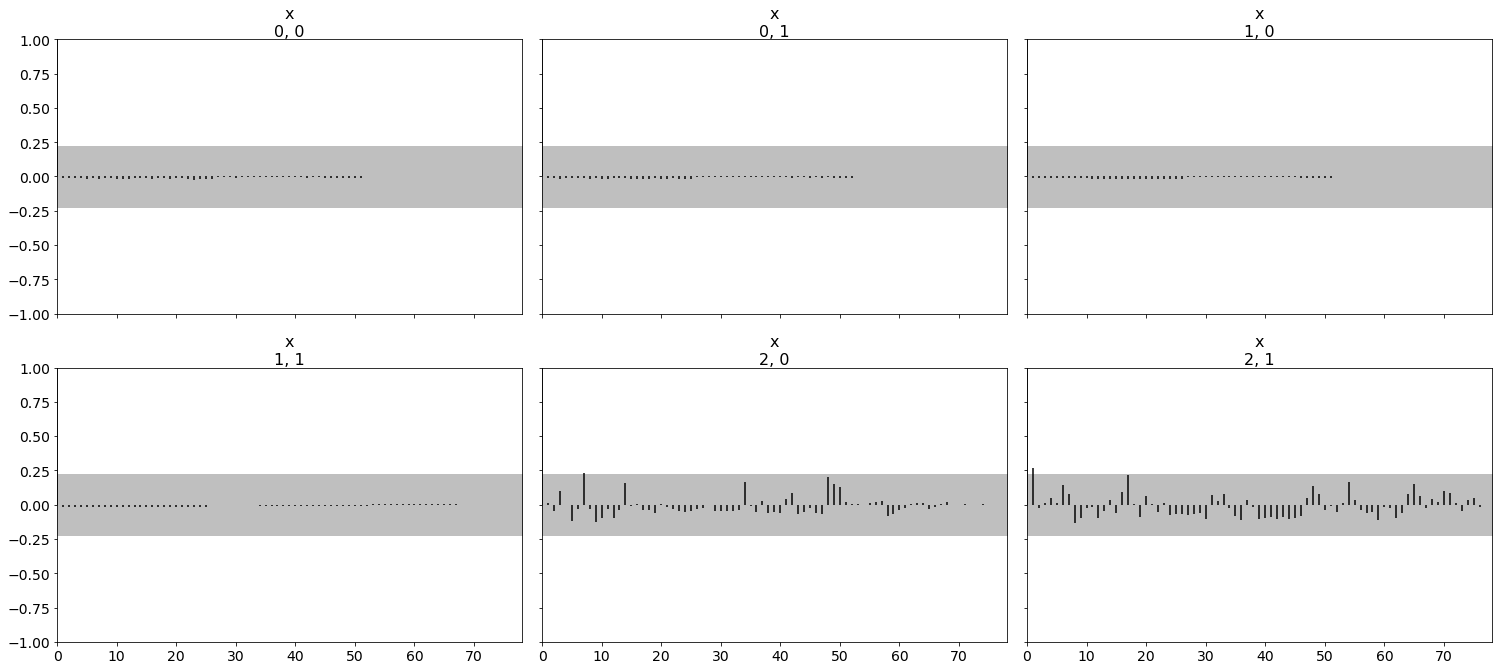

In [101]:
var1 = np.array([
      amplitudes[0],
      length_scales[0], observations1_[0]])
az.plot_autocorr(var1)
'''
, var_names=("amplitudes",
      "length_scales",
      "observation_noise_variances"))'''

In [102]:
numElems = len(Y)
sample = samples[0] + mean_fn(observation_index_points[:,0], r.t2bv(10**(np.array(observation_index_points[:,1]))), a ,b ,c ,d)
idx = np.round(np.linspace(0, len(np.array(sample).reshape(numElems**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data

mu_test = (np.array(sample).reshape(numElems**2)[idx])
sd_test = (np.array(var).reshape(numElems**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)



Text(0, 0.5, 'GP Uncertainty')

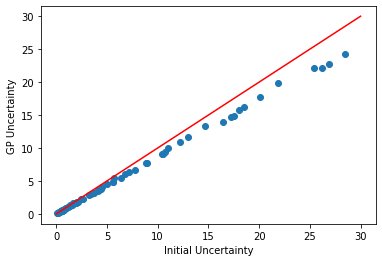

In [103]:
x = np.linspace(0, 30)
plt.plot(x, x , 'r')
plt.scatter(np.sort(p_error), vals[1]**2)
plt.xlabel('Initial Uncertainty')
plt.ylabel('GP Uncertainty')

In [104]:
vals[1].shape

(78,)

(array([0.0147044 , 0.        , 0.        , 0.        , 0.        ,
        0.0147044 , 0.        , 0.0294088 , 0.        , 0.        ,
        0.0147044 , 0.04411319, 0.08822639, 0.05881759, 0.08822639,
        0.11763518, 0.17645278, 0.17645278, 0.19115717, 0.13233958]),
 array([-1.73355961e+00, -8.61676738e-01,  1.02061341e-02,  8.82089006e-01,
         1.75397188e+00,  2.62585475e+00,  3.49773762e+00,  4.36962049e+00,
         5.24150337e+00,  6.11338624e+00,  6.98526911e+00,  7.85715198e+00,
         8.72903485e+00,  9.60091773e+00,  1.04728006e+01,  1.13446835e+01,
         1.22165663e+01,  1.30884492e+01,  1.39603321e+01,  1.48322150e+01,
         1.57040978e+01]),
 <a list of 20 Patch objects>)

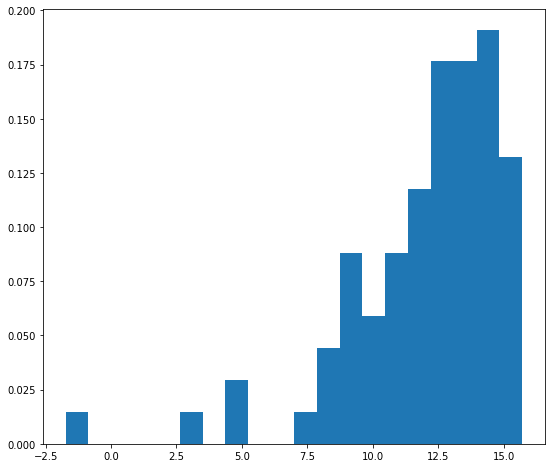

In [105]:
per_error = 100*(np.sort(p_error) - vals[1]**2)/np.sort(p_error)
plt.figure(figsize=(9,8))
plt.hist(per_error, density=True, bins=20)

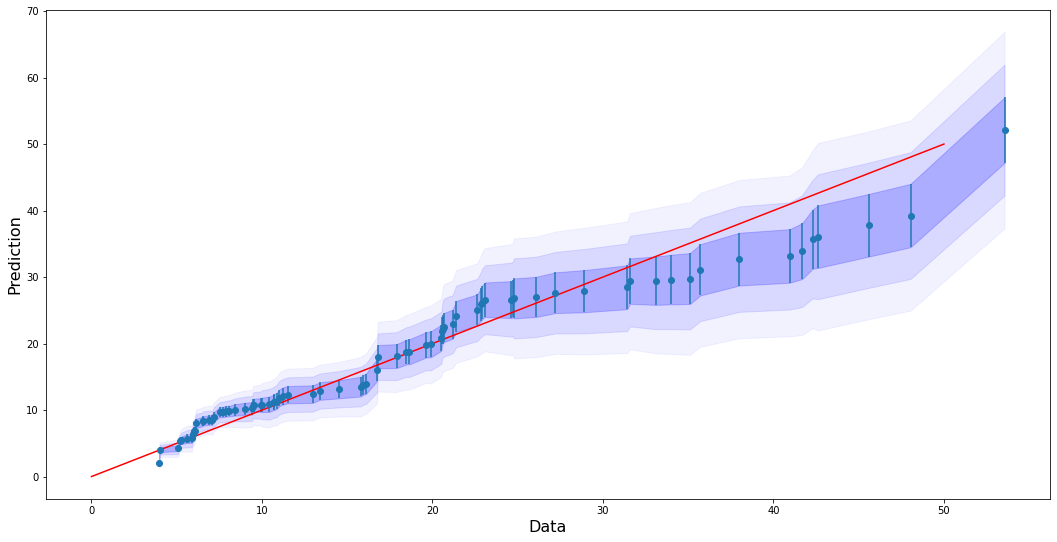

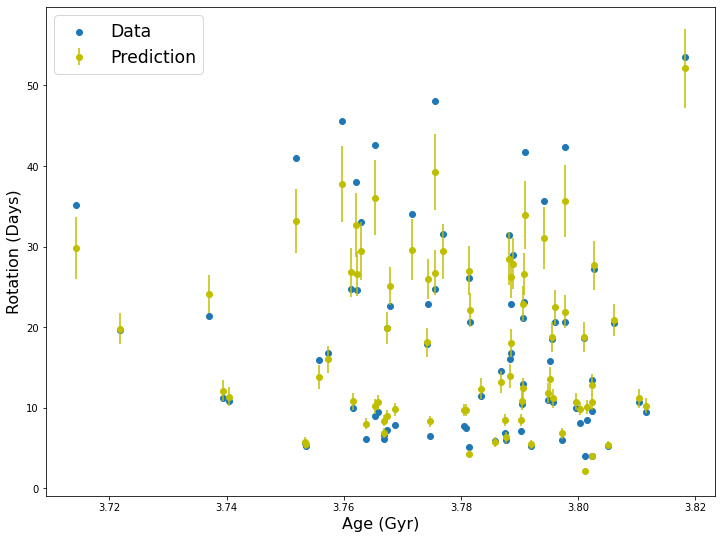

In [106]:
plt.figure(figsize=(18,9))
x = np.linspace(0, 50)
font = {'size': 16,
        }
#plt.errorbar(np.sort(data[::al, 1]), vals[0,:], yerr=vals[1,:]**0.5, fmt='bo')
plt.fill_between(np.sort(p), vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], color='blue', alpha=0.2)
plt.fill_between(np.sort(p), vals[0,:] - 2*vals[1,:], vals[0,:] + 2*vals[1,:], color='blue', alpha=0.1)
plt.fill_between(np.sort(p), vals[0,:] - 3*vals[1,:], vals[0,:] + 3*vals[1,:], color='blue', alpha=0.05)

plt.errorbar(np.sort(p), np.sort(mu_test), yerr=vals[1,:], fmt='o')
plt.plot(x, x , 'r')
plt.xlabel('Data', fontdict=font)
plt.ylabel('Prediction', fontdict=font)

plt.figure(figsize=(12,9))
plt.errorbar(X2, np.sort(vals[0]), yerr=vals[1], fmt='o', c='y', label='Prediction')
plt.scatter(X2, np.sort(p), label='Data')
plt.xlabel('Age (Gyr)', fontdict=font)
plt.ylabel('Rotation (Days)', fontdict=font)
plt.legend(fontsize='xx-large')


(78,)


Text(0, 0.5, 'Frequency')

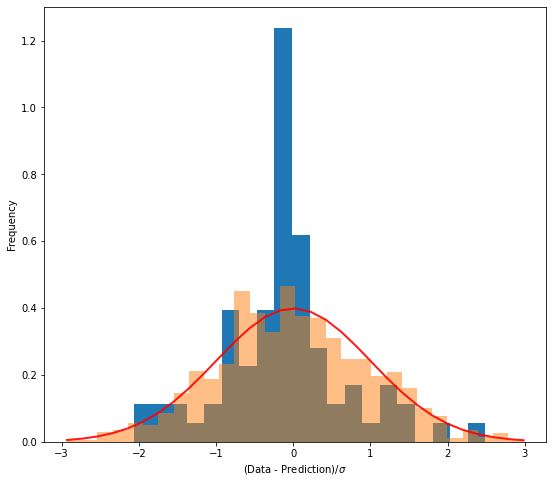

In [107]:
Z = (np.sort(p)-vals[0,:])/(vals[1,:]**2 +p_error**2)**0.5
print(Y.shape)
plt.figure(figsize=(9,8))
plt.hist(Z, density=True, bins=20)
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', alpha=0.9)
plt.xlabel('(Data - Prediction)/$\sigma$')
plt.ylabel('Frequency')

(78,)


Text(0, 0.5, 'Frequency')

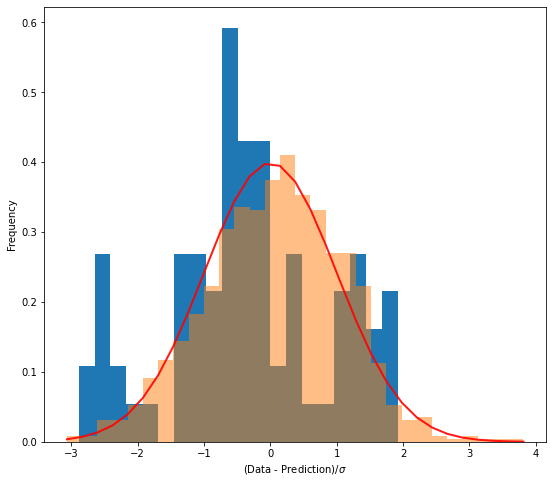

In [108]:
Z = (np.sort(p)-vals[0,:])/vals[1,:]
print(Y.shape)
for i in range(0,len(Z)-1):
  if Z[i]>5:
    x = Z.tolist()
    x.pop(i)
    Z = np.array(x)
plt.figure(figsize=(9,8))
plt.hist(Z, density=True, bins=20)
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', alpha=0.9)
#plt.xlim((-5,5))
plt.xlabel('(Data - Prediction)/$\sigma$')
plt.ylabel('Frequency')

In [109]:
import collections 
PooledModel = collections.namedtuple('PooledModel', ['Amplitude1','Length_Scale1', 'Obs'])
samplesN = [
      amplitudes[49],
      length_scales[49],
      observations1_[49]
]
pooled_samples = PooledModel._make(samplesN)

In [110]:
for var2, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var2, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  Amplitude1 :	 0.9871805665272457
R-hat for  Length_Scale1 :	 0.9871795428143351
R-hat for  Obs :	 1.2194806813226342


In [111]:
import seaborn as sns
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

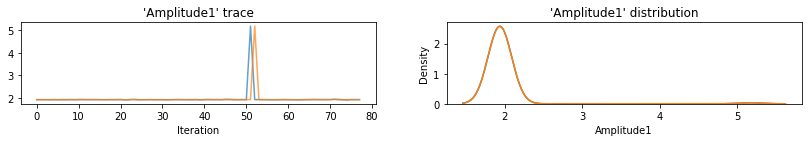

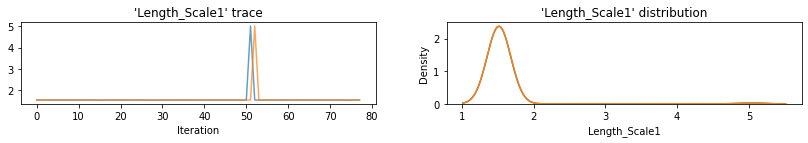

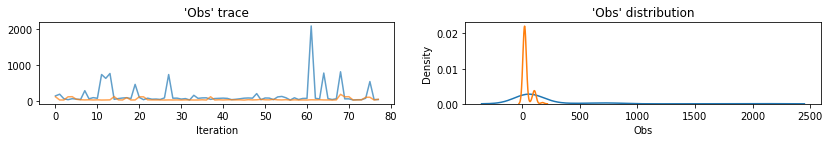

In [112]:
for var1, var_samples in pooled_samples._asdict().items():
  plot_traces(var1, samples=var_samples, num_chains=2)

(array([ 4., 18.,  7., 10., 11., 12.,  9.,  2.,  2.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.38564024e-01, -2.20979964e-01, -3.39590437e-03,  2.14188155e-01,
         4.31772215e-01,  6.49356275e-01,  8.66940335e-01,  1.08452439e+00,
         1.30210845e+00,  1.51969251e+00,  1.73727657e+00,  1.95486063e+00,
         2.17244469e+00,  2.39002875e+00,  2.60761281e+00,  2.82519687e+00,
         3.04278093e+00,  3.26036499e+00,  3.47794905e+00,  3.69553311e+00,
         3.91311717e+00]),
 <a list of 20 Patch objects>)

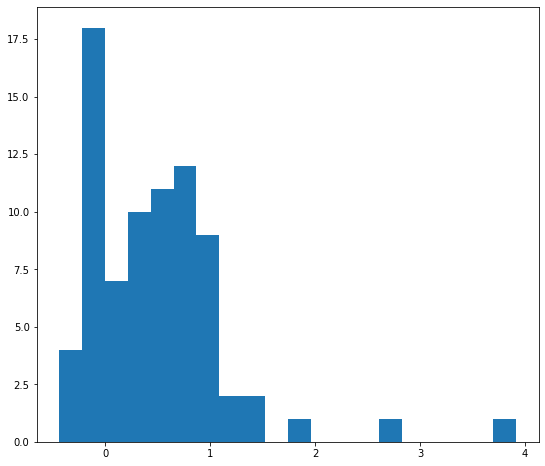

In [117]:
D = (np.log10(observation_index_points_1[:,0])- observation_index_points[:,0])/observation_index_points[:,0]
plt.figure(figsize=(9,8))
plt.hist(D, bins=20)

(array([0.61120859, 1.22241718, 1.62988958, 1.22241718, 1.83362578,
        3.87098775, 2.24109817, 0.2037362 , 0.40747239, 0.61120859,
        0.        , 0.2037362 , 0.        , 0.2037362 , 0.40747239,
        0.81494479, 0.2037362 , 0.        , 0.        , 0.2037362 ]),
 array([-0.23805639, -0.17512937, -0.11220234, -0.04927532,  0.01365171,
         0.07657873,  0.13950576,  0.20243278,  0.26535981,  0.32828683,
         0.39121386,  0.45414088,  0.51706791,  0.57999494,  0.64292196,
         0.70584899,  0.76877601,  0.83170304,  0.89463006,  0.95755709,
         1.02048411]),
 <a list of 20 Patch objects>)

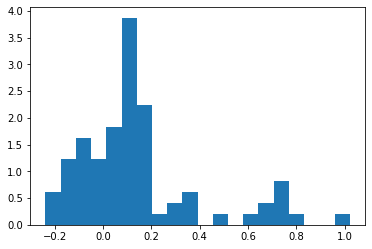

In [118]:
D_2 = (np.log(observation_index_points_1[:,0]) - observation_index_points[:,1])/observation_index_points[:,1]
plt.hist(D_2, density=True, bins=20)

array([1.10406407, 1.19996478, 0.80374894, 0.73721191, 1.8916048 ,
       0.96816186, 2.12421173, 0.85258386, 1.18478998, 1.23837423,
       1.89761986, 2.0239024 , 1.84845481, 1.57957646, 0.93738664,
       1.35840916, 2.18888994, 1.61514162, 2.25968803, 1.70837786,
       0.87941926, 0.72183181, 1.87180218, 0.66598151, 1.84657904,
       0.90559372, 1.06629569, 1.97858476, 1.03840216, 1.02245093,
       1.17557333, 2.29890834, 0.8457395 , 1.27851425, 1.82937633,
       1.34309976, 1.26508672, 1.06077196, 1.34807315, 2.08318453,
       1.49373521, 2.26301232, 0.96317432, 1.7227666 , 1.54611465,
       0.95551145, 1.87882362, 2.08925572, 0.46693643, 0.76732658,
       1.9357155 , 0.97421996, 0.84586827, 1.83899287, 1.07178907,
       1.11981916, 0.89910388, 1.06077196, 2.05923883, 1.94718077,
       1.86097454, 0.87279851, 0.74668795, 1.11458406, 1.96747593,
       1.63705308, 1.84213568, 1.96009478, 2.36706111, 1.2781522 ,
       1.90359895, 2.32532458, 1.37992411, 0.69828396, 1.89814